# SPECFEM Users Workshop -- Day 2 (Oct. 6, 2022)

## Day 2C: Sensitivity Kernels (Liu & Tromp 2006)

- This notebook gives a tour of the example in the SPECFEM3D_Cartesian package, on how to regenerate the sensitivity kernels in [Liu&Tromp 2006](https://pubs.geoscienceworld.org/ssa/bssa/article/96/6/2383/146674/Finite-Frequency-Kernels-Based-on-Adjoint-Methods)       
- These instructions should be run from inside the Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).

-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_2c_kernels_liutromp2006.ipynb  
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2c_kernels_liutromp2006.ipynb  
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb  
- SPECFEM3D_Cartesian User Manual: https://github.com/geodynamics/specfem3d/blob/devel/doc/USER_MANUAL/manual_SPECFEM3D_Cartesian.pdf
- SPECFEM3D_Cartesian GitHub Repository: https://github.com/geodynamics/specfem3d/tree/devel
- SPECFEM3D_Cartesian Liu&Tromp 2006 Sensitivity Kernel Example - https://github.com/geodynamics/specfem3d/tree/devel/EXAMPLES/sensitivity_kernels_liutromp2006
- Liu & Tromp 2006 paper - https://pubs.geoscienceworld.org/ssa/bssa/article/96/6/2383/146674/Finite-Frequency-Kernels-Based-on-Adjoint-Methods

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)

>__NOTE:__
- In this notebook, we will not be running any simulations. It's just a presentation of some of the steps needed to regenerate some of the kernels in [Liu&Tromp 2006](https://pubs.geoscienceworld.org/ssa/bssa/article/96/6/2383/146674/Finite-Frequency-Kernels-Based-on-Adjoint-Methods), and how the pre-saved regenerated kernels look like.
- All instructions provided in this notebook as [README](https://github.com/geodynamics/specfem3d/blob/devel/EXAMPLES/sensitivity_kernels_liutromp2006/README) file excerpts, are **not** for running the example within this container setup, but in a separate SPECFEM3D_cartesian set up based on the instructions given in the README file itself.

------------

In [1]:
# Python packages we will need for this notebook
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

In [2]:
# Where to find the example's instructions
%cd /home/scoped/specfem3d/EXAMPLES/sensitivity_kernels_liutromp2006/

/home/scoped/specfem3d/EXAMPLES/sensitivity_kernels_liutromp2006


In [3]:
# Look at the files and folders
! ls *

README	source_time_function.txt

DATA:
FORCESOLUTION_P_SV  meshfem3D_files  STATIONS
FORCESOLUTION_SH    Par_file	     STATIONS_ADJOINT

REF_ADJ_SRC:
P  PSSP  S  SS

REF_KERNELS:
P_alpha_kernel_3D.png	  PSSP_kappa_kernel_3D.png  S_alpha_kernel_3D.png
P_beta_kernel_3D.png	  PSSP_mu_kernel_3D.png     S_beta_kernel_3D.png
PSSP_alpha_kernel_3D.png  PSSP_rho_kernel_3D.png    SS_alpha_kernel_3D.png
PSSP_beta_kernel_3D.png   PSSP_rhop_kernel_3D.png   SS_beta_kernel_3D.png

REF_SEIS:
P_SV_simulation  SH_simulation


## 1) Setup

>__Note:__ All instructions provided in this notebook as [README](https://github.com/geodynamics/specfem3d/blob/devel/EXAMPLES/sensitivity_kernels_liutromp2006/README) file excerpts, are **not** for running the example within this container setup, but in a separate SPECFEM3D_cartesian set up based on the instructions given in the README file itself.

In [4]:
# Setup instructions (NOT for setting the example for running within this container)
! head -33 README | tail -n 23


1.1. Run the default homogeneous halfspace example at EXAMPLES/homogeneous_halfspace 

1.2. Set 'USER_T0' = 10.0d0 in ./setup/constants.h and rebuild the solver.
     > make xspecfem3D

     Note: Setting a large enough USER_T0 value before a simulation is a safety measure to have a consistent simulation start time,
           especially in simulations where there are multiple events with different half durations. Different simulation start times
           could cause a problem when making adjoint sources and aligning time steps.

1.3. Compile the utility xcreate_adjsrc_traveltime.
     > cd ./utils/adjoint_sources/traveltime
     > make
     > cd ../../..

1.4. Compile the utility xcombine_vol_data_vtk.
     > make xcombine_vol_data_vtk

1.5. Use the provided DATA folder as specfem3d's input DATA folder.
     > cp -r EXAMPLES/sensitivity_kernels_liutromp2006/DATA .

1.6. Copy the file 'source_time_function.txt' from this data folder to the specfem working directory.



-----------

## 2) Forward Simulation

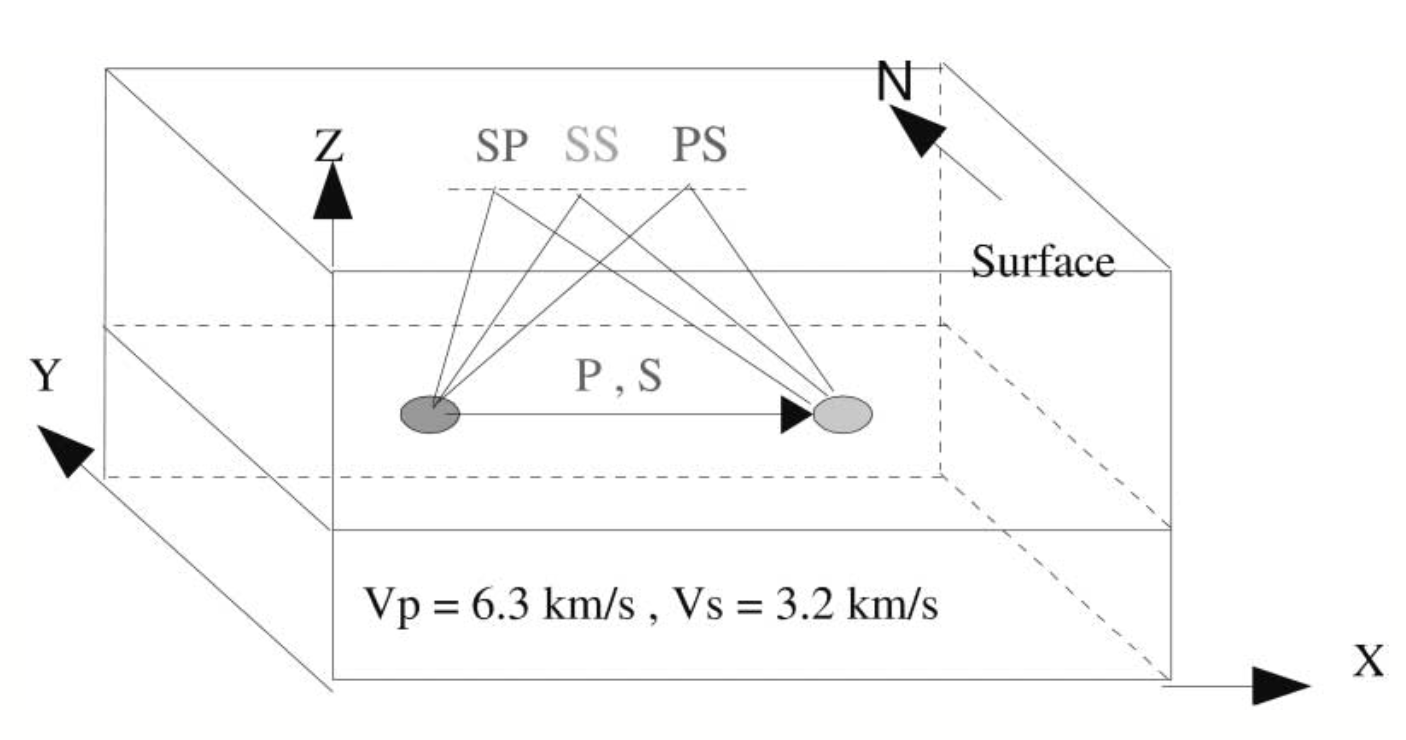

**Fig.** The homogeneous halfspace model, with the source station geometry, and the ray paths, modified from [Liu & Tromp 2006](https://pubs.geoscienceworld.org/ssa/bssa/article/96/6/2383/146674/Finite-Frequency-Kernels-Based-on-Adjoint-Methods). The source and the station are 100 km apart, at a depth of 40 km from the surface.

In [5]:
# Forward simulation instructions (NOT for running simulations within this container)
! head -55 README | tail -n 18


2.1. The example consists of two different simulations and hence the two different 'FORCESOLUTION_*' files in the data folder.
     Copy the 'FORCESOLUTION_*' file you wish to run and name it as 'FORCESOLUTION'.

2.2. FORCESOLUTION_SH will produce the seismogram in the top figure of figure 3(a).
     > xmgrace XX.R00-01.HXY.semd
     FORCESOLUTION_P_SV will produce the seismogram in the top figure of figure 3(b).
     > xmgrace XX.R00-01.HXX.semd

2.3. Run the simulation with following parameters in the Par_file -
     SIMULATION_TYPE = 1
     SAVE_FORWARD = .true.

2.4. Compare the generated seismograms with the ones provided in the REF_SEIS folder
     > xmgrace OUTPUT_FILES/*.semd
     > xmgrace EXAMPLES/kernel_liutromp2006/REF_SEIS/****_simulation/*.semd
     where **** will depend on the simulation type



In [6]:
# Check the source file for the P_SV simulation
! cat DATA/FORCESOLUTION_P_SV

FORCE  001
time shift:     		  0.0000
f0:             		  0.0
latorUTM:       		  0.0
longorUTM:                   -50000.0
depth:          		  40.0
factor force source:              12d7
component dir vect source E:      1.d0
component dir vect source N:      0.d0
component dir vect source Z_UP:   0.d0
source_time_function.txt


In [7]:
# Check the source file for the SH simulation
! cat DATA/FORCESOLUTION_SH

FORCE  001
time shift:     		  0.0000
f0:             		  0.0
latorUTM:       		  0.0
longorUTM:                   -50000.0
depth:          		  40.0
factor force source:              45d6
component dir vect source E:      0.d0
component dir vect source N:      1.d0
component dir vect source Z_UP:   0.d0
source_time_function.txt


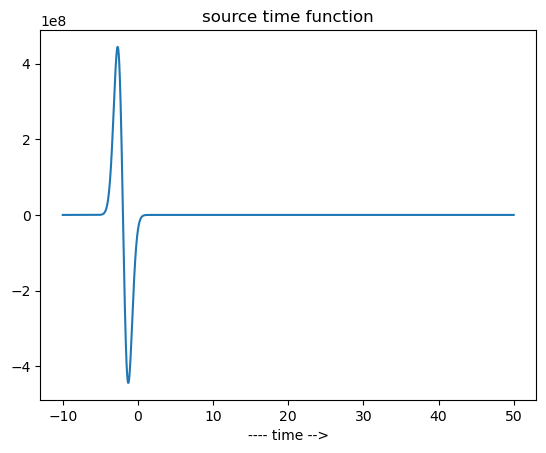

In [8]:
# Source Time Function

STF = np.genfromtxt("source_time_function.txt", dtype=None)
t = STF[0]*np.arange(len(STF)-1) - 10

plt.title("source time function")
plt.xlabel("---- time -->")

plt.plot(t,STF[1:])
plt.show()

>__NOTE:__ The external source time function, as required by SPECFEM3D_Cartesian, is the cumulative moment/force vs. time function, and **not** the moment/force rate vs. time function

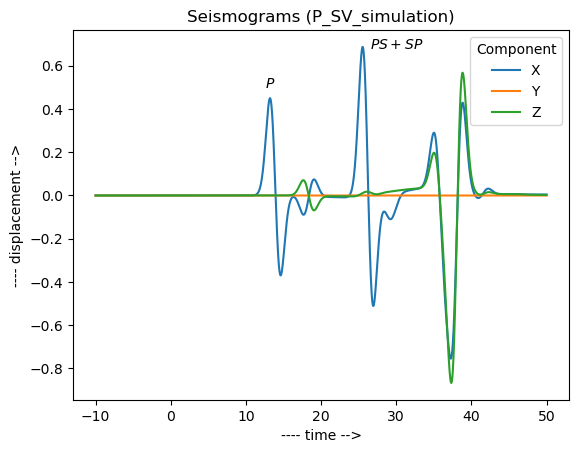

In [9]:
# Seismograms for P_SV_simulation

R01_X = np.genfromtxt("REF_SEIS/P_SV_simulation/XX.R00-01.HXX.semd", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_SEIS/P_SV_simulation/XX.R00-01.HXY.semd", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_SEIS/P_SV_simulation/XX.R00-01.HXZ.semd", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Seismograms (P_SV_simulation)")
plt.xlabel("---- time -->")
plt.ylabel("---- displacement -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.text(12.5,.50,r'$P$',fontsize=10)
plt.text(26.5,.68,r'$PS+SP$',fontsize=10)

plt.legend(title="Component")
plt.show()

-----------

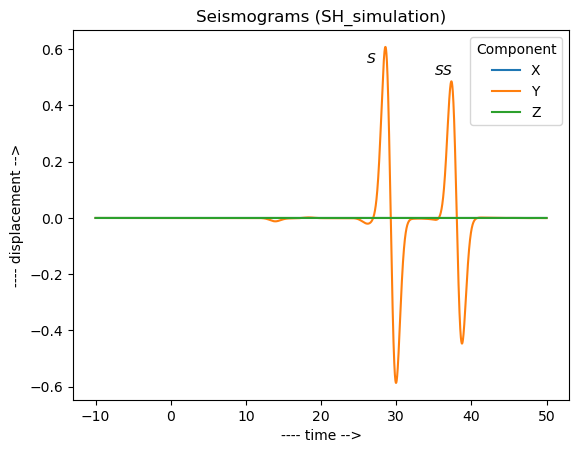

In [10]:
# Seismograms for SH_simulation

R01_X = np.genfromtxt("REF_SEIS/SH_simulation/XX.R00-01.HXX.semd", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_SEIS/SH_simulation/XX.R00-01.HXY.semd", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_SEIS/SH_simulation/XX.R00-01.HXZ.semd", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Seismograms (SH_simulation)")
plt.xlabel("---- time -->")
plt.ylabel("---- displacement -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.text(26,.55,r'$S$',fontsize=10)
plt.text(35,.51,r'$SS$',fontsize=10)

plt.legend(title="Component")
plt.show()

## 3) Adjoint Simulation

In [11]:
# Adjoint simulation instructions (NOT for running simulations within this container)
! head -86 README | tail -n 28

3. To run the adjoint simulation and generate the kernels -

3.1. Create adjoint sources for the kernel of interest -

     a. P kernel -      
        > ./utils/adjoint_sources/traveltime/xcreate_adjsrc_traveltime 10 18 1 OUTPUT_FILES/XX.R00-01.HX*.semd
   
     b. S kernel -
        > ./utils/adjoint_sources/traveltime/xcreate_adjsrc_traveltime 24 34 2 OUTPUT_FILES/XX.R00-01.HX*.semd

     c. SS kernel -
        > ./utils/adjoint_sources/traveltime/xcreate_adjsrc_traveltime 34 44 2 OUTPUT_FILES/XX.R00-01.HX*.semd

     d. PS + SP kernel -
        > ./utils/adjoint_sources/traveltime/xcreate_adjsrc_traveltime 24 30 1 OUTPUT_FILES/XX.R00-01.HX*.semd

3.2. Move adjoint sources to the required folder -
     > mkdir SEM
     > mv OUTPUT_FILES/*.adj SEM/.  

3.3. Compare the created adjoint sources with the ones provided in the REF_ADJ_SRC folder
     > xmgrace SEM/*.adj
     > xmgrace EXAMPLES/kernel_liutromp2006/REF_ADJ_SRC/****/*.adj
     where **** will depend on the kernel type

3.4. 

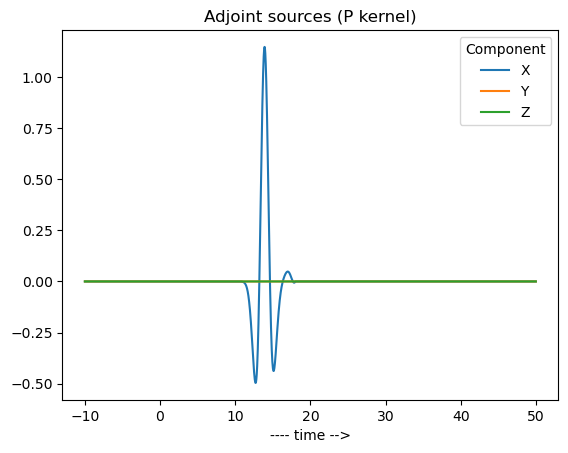

In [12]:
# Adjoint sources for P kernels

R01_X = np.genfromtxt("REF_ADJ_SRC/P/XX.R00-01.HXX.adj", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_ADJ_SRC/P/XX.R00-01.HXY.adj", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_ADJ_SRC/P/XX.R00-01.HXZ.adj", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Adjoint sources (P kernel)")
plt.xlabel("---- time -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.legend(title="Component")
plt.show()

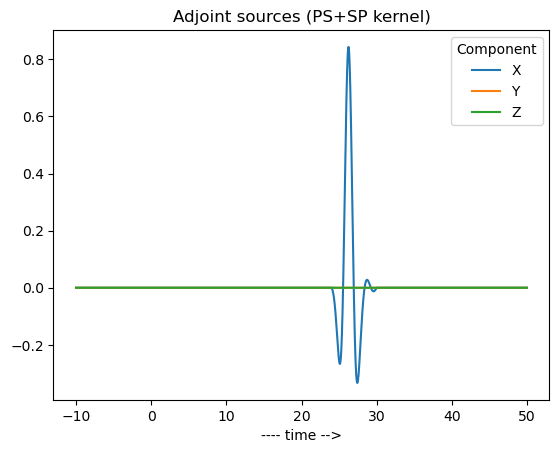

In [13]:
# Adjoint sources for PS+SP kernels

R01_X = np.genfromtxt("REF_ADJ_SRC/PSSP/XX.R00-01.HXX.adj", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_ADJ_SRC/PSSP/XX.R00-01.HXY.adj", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_ADJ_SRC/PSSP/XX.R00-01.HXZ.adj", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Adjoint sources (PS+SP kernel)")
plt.xlabel("---- time -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.legend(title="Component")
plt.show()

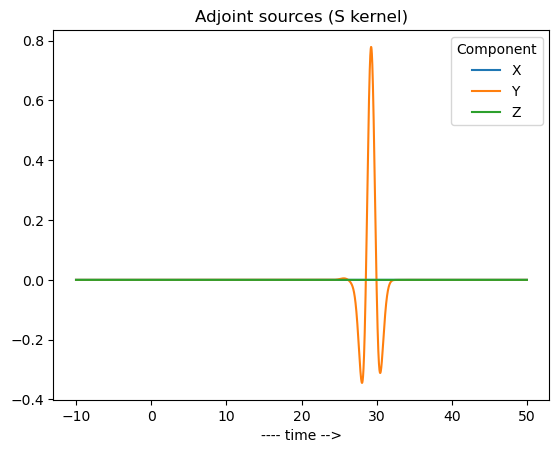

In [14]:
# Adjoint sources for S kernels

R01_X = np.genfromtxt("REF_ADJ_SRC/S/XX.R00-01.HXX.adj", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_ADJ_SRC/S/XX.R00-01.HXY.adj", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_ADJ_SRC/S/XX.R00-01.HXZ.adj", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Adjoint sources (S kernel)")
plt.xlabel("---- time -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.legend(title="Component")
plt.show()

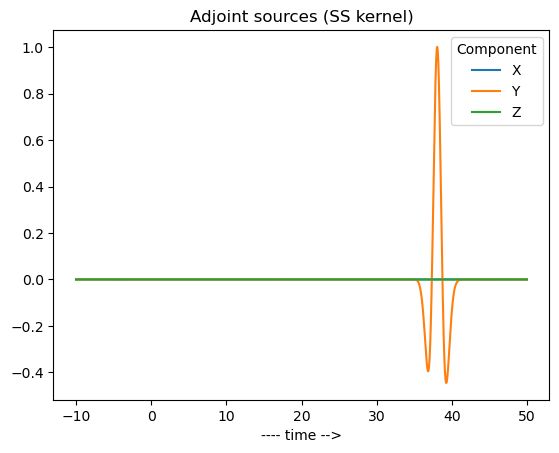

In [15]:
# Adjoint sources for SS kernels

R01_X = np.genfromtxt("REF_ADJ_SRC/SS/XX.R00-01.HXX.adj", dtype=None, names=("time","HXX"))
R01_Y = np.genfromtxt("REF_ADJ_SRC/SS/XX.R00-01.HXY.adj", dtype=None, names=("time","HXY"))
R01_Z = np.genfromtxt("REF_ADJ_SRC/SS/XX.R00-01.HXZ.adj", dtype=None, names=("time","HXZ"))

t = R01_X["time"]

plt.title("Adjoint sources (SS kernel)")
plt.xlabel("---- time -->")

plt.plot(t,R01_X["HXX"],label="X")
plt.plot(t,R01_Y["HXY"],label="Y")
plt.plot(t,R01_Z["HXZ"],label="Z")

plt.legend(title="Component")
plt.show()

-----------

## 4) Kernel Visualization

In [16]:
# Visualization instructions (NOT for running within this container)
! tail -n 39 README


4.1. Combine kernel slices into a vtk file -
     ./bin/xcombine_vol_data_vtk 0 39 ****_kernel DATABASES/ OUTPUT_FILES/ 0
     where **** can be replaced with alpha, beta, kappa, mu, rho, and rhop
     For a higher resolution rendering of the kernels, replace '0' at the end with '1'

4.2. View the kernel of interest -
     The kernels are stored in the OUTPUT_FILES folder as '****_kernel.vtk' and can be viewed using paraview.
     Change colormap to 'red to blue rainbow' and follow the steps below -

     a. P kernel
        Slice the 3D block with planes having normals as the x-axis, y-axis and z-axis, and origins at (0,0,-40000) each
        Colormap scaling - 
        K_alpha -  -0.7e-12 to 0.7e-12
        K_beta  -  -0.9e-13 to 0.9e-13 (Figure not in the paper)   
   
     b. S kernel
        Slice the 3D block with planes having normals as the x-axis, y-axis and z-axis, and origins at (0,0,-40000) each 
        Colormap scaling -
        K_alpha -  -0.1e-13 to 0.1e-13 (Figure not

>__NOTE:__ For detailed instructions on how to use paraview for kernel visualization, read the final section of this [file](https://github.com/geodynamics/specfem3d/blob/devel/EXAMPLES/homogeneous_halfspace_HEX8_elastic_absorbing_Stacey_5sides/README_kernel)

In [17]:
# Pre-saved reference kernel figures
%cd /home/scoped/specfem3d/EXAMPLES/sensitivity_kernels_liutromp2006/REF_KERNELS/

/home/scoped/specfem3d/EXAMPLES/sensitivity_kernels_liutromp2006/REF_KERNELS


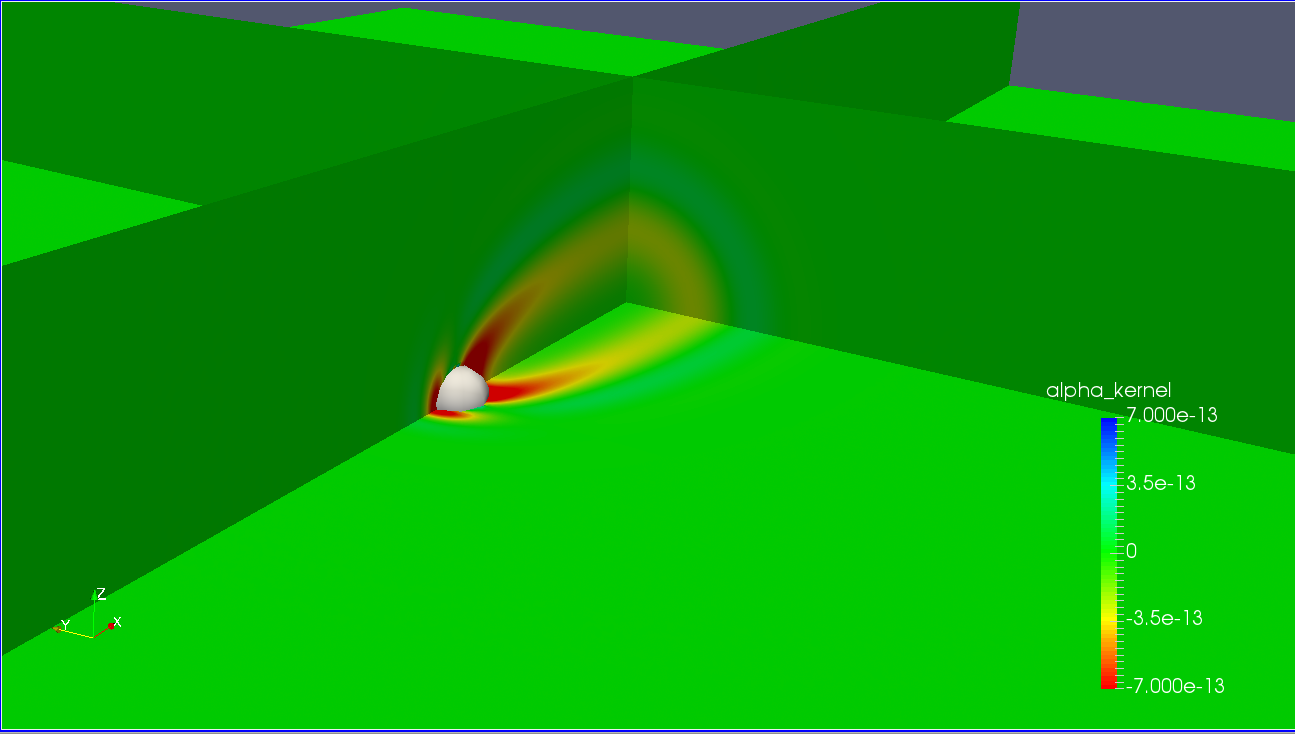

In [18]:
Image("P_alpha_kernel_3D.png")

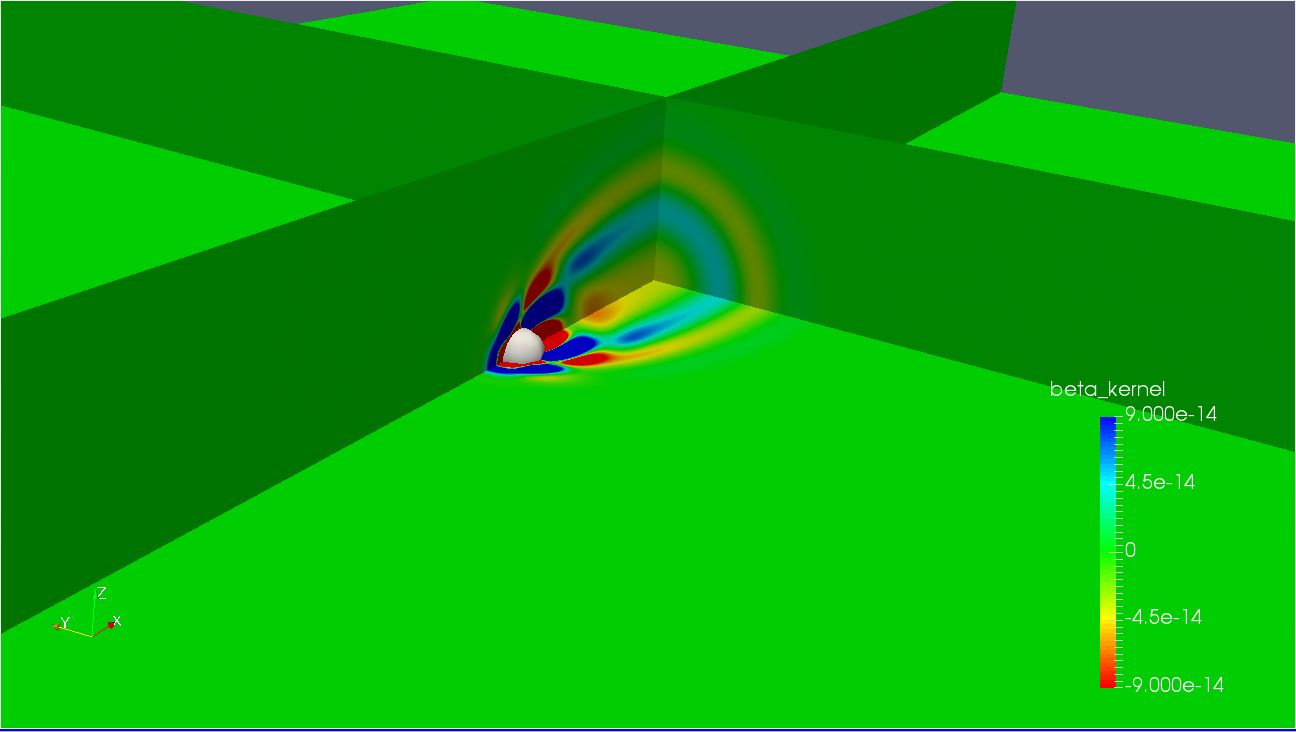

In [19]:
Image("P_beta_kernel_3D.png")

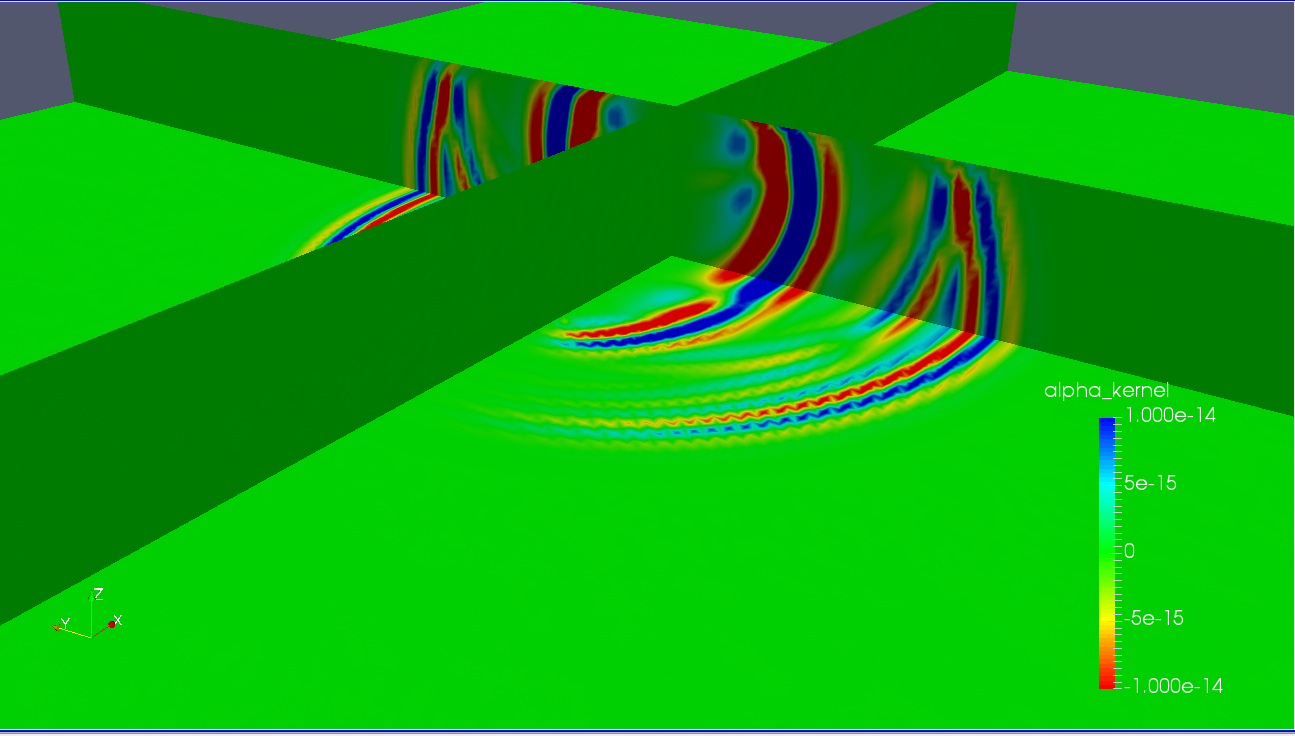

In [20]:
Image("S_alpha_kernel_3D.png")

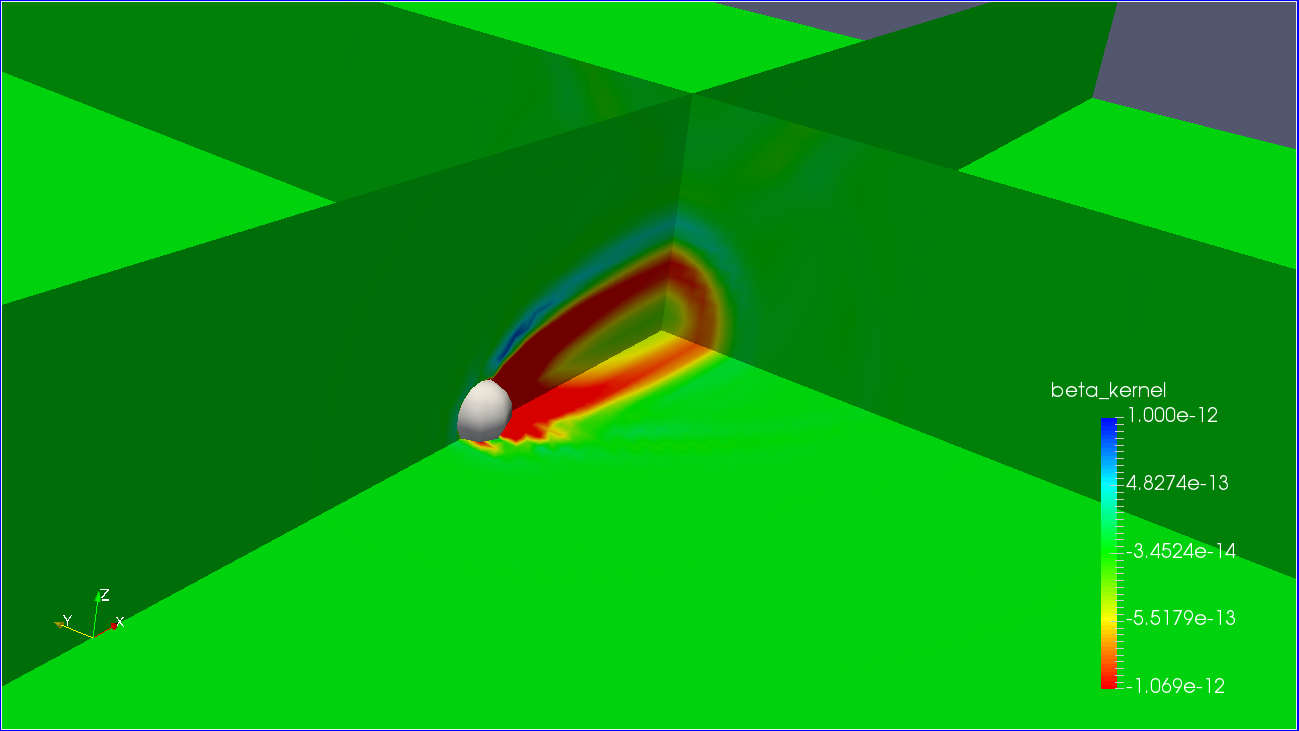

In [21]:
Image("S_beta_kernel_3D.png")

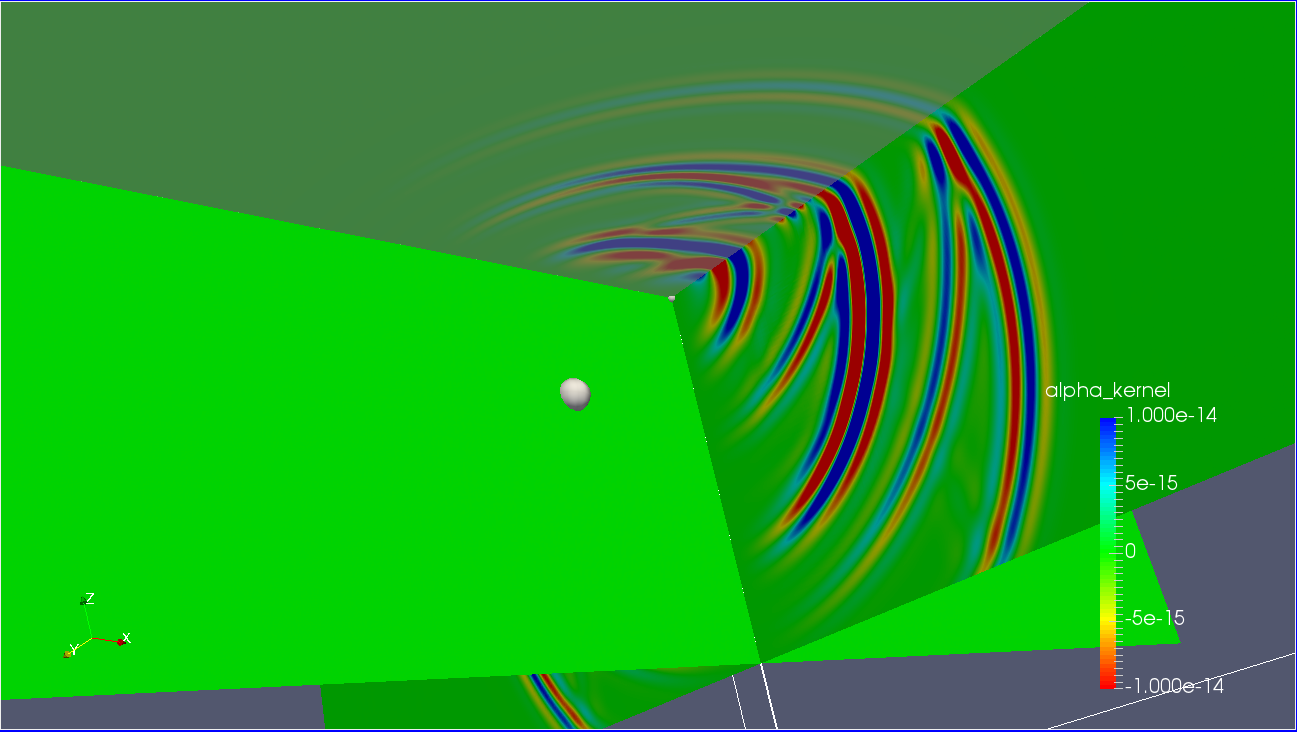

In [22]:
Image("SS_alpha_kernel_3D.png")

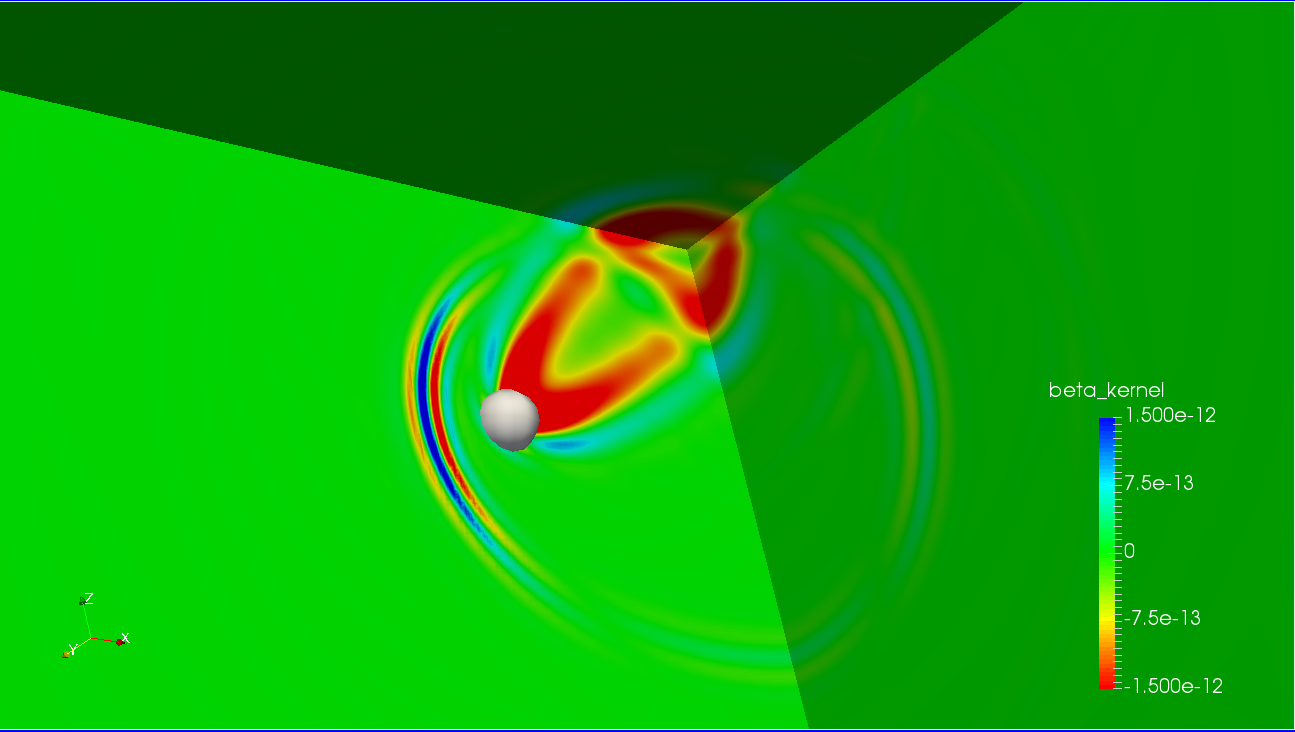

In [23]:
Image("SS_beta_kernel_3D.png")

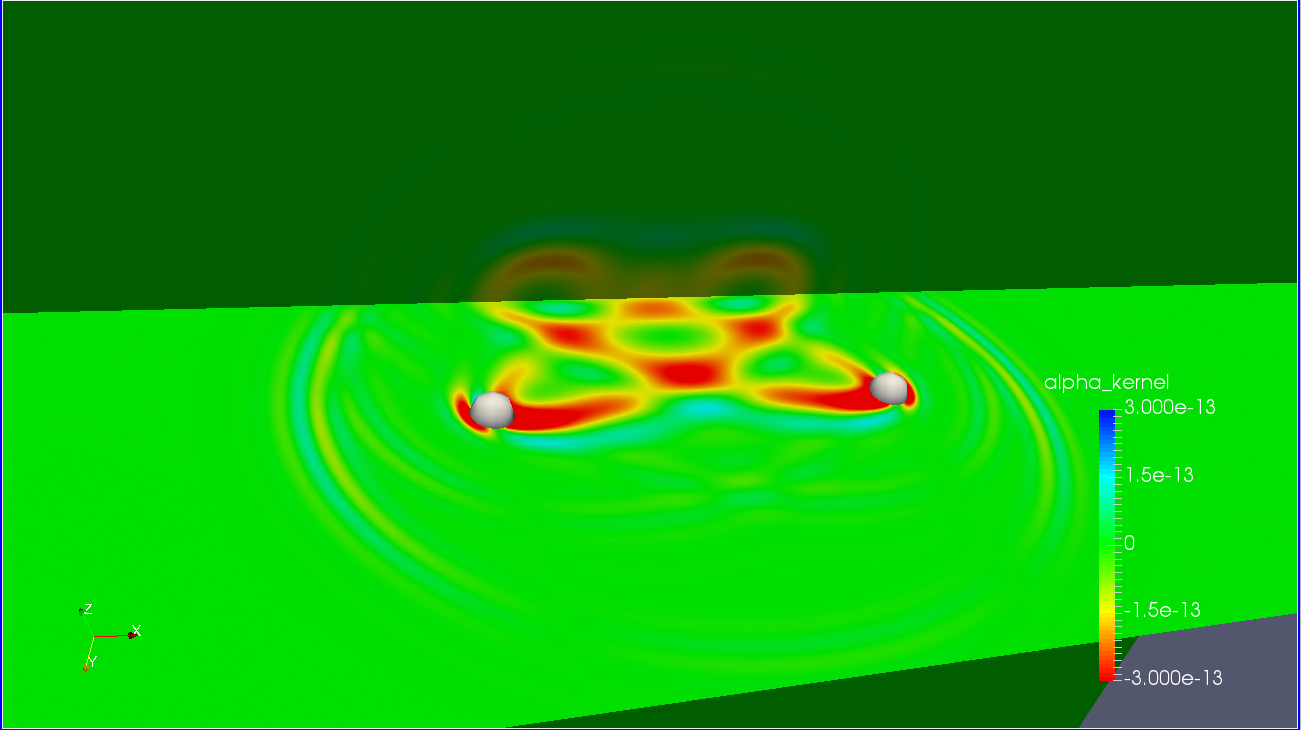

In [24]:
Image("PSSP_alpha_kernel_3D.png")

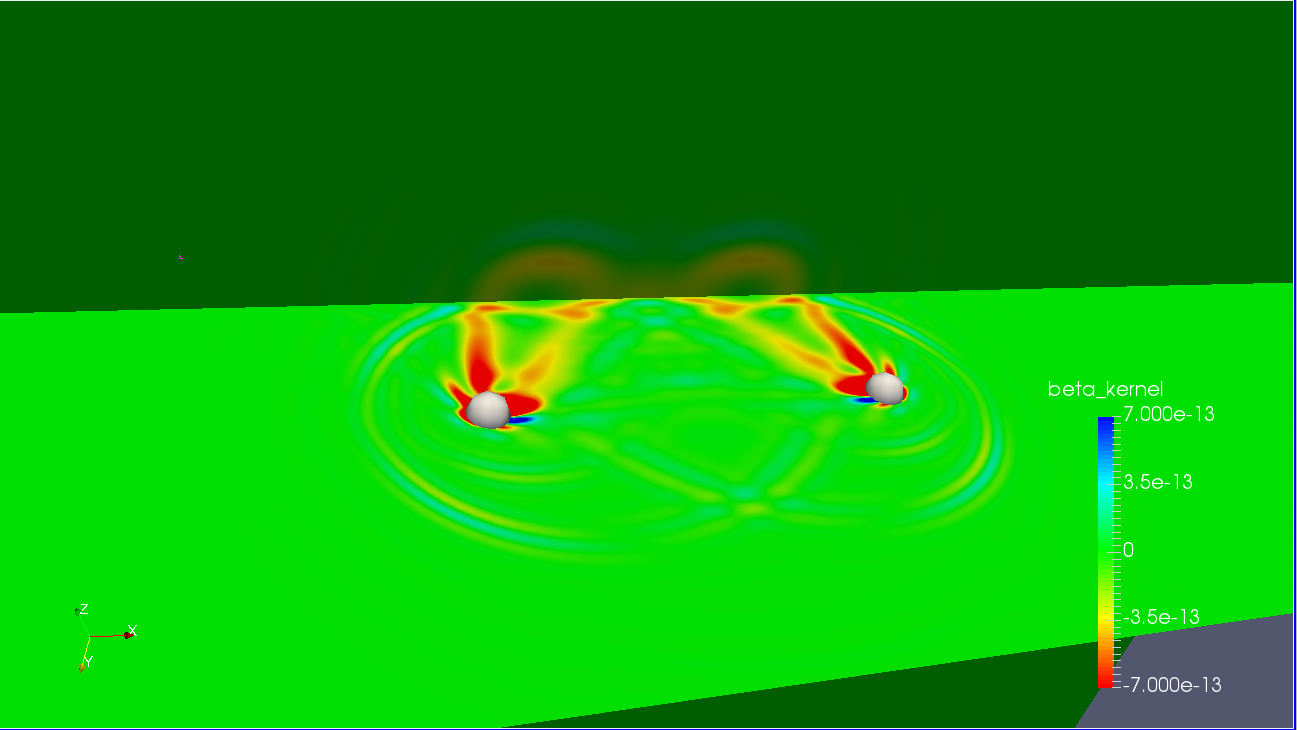

In [25]:
Image("PSSP_beta_kernel_3D.png")

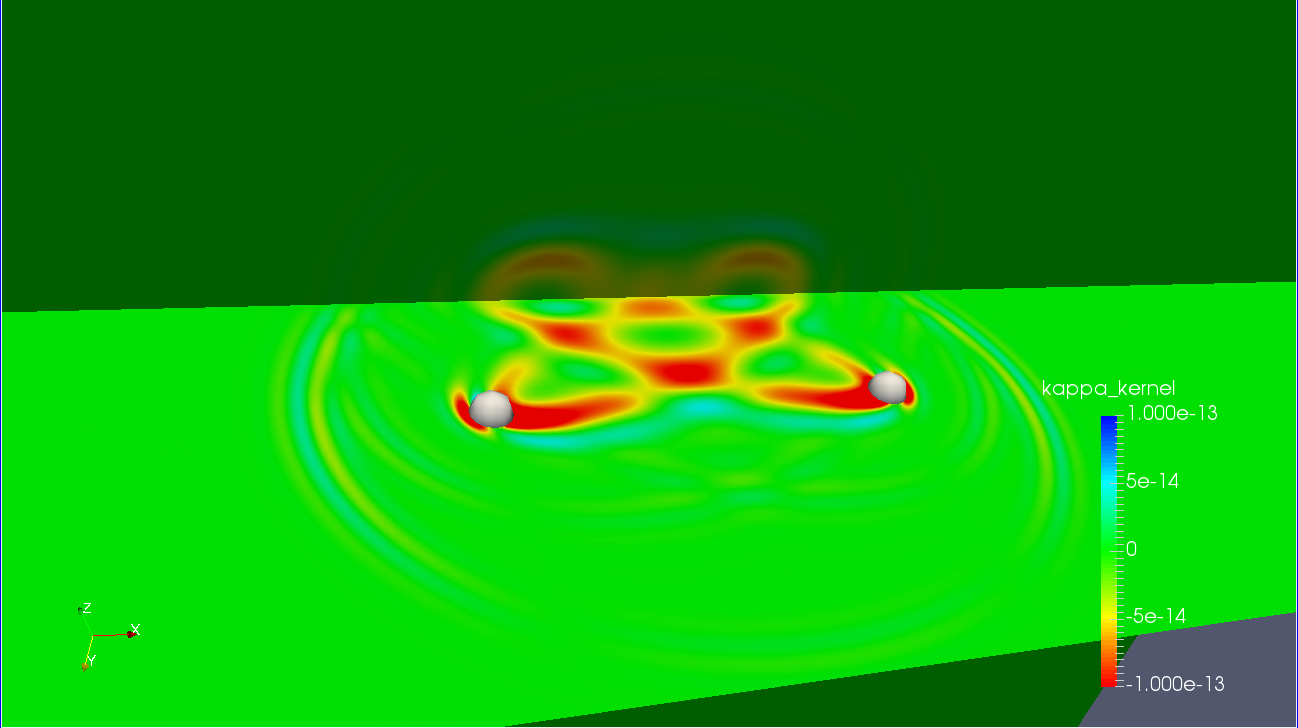

In [26]:
Image("PSSP_kappa_kernel_3D.png")

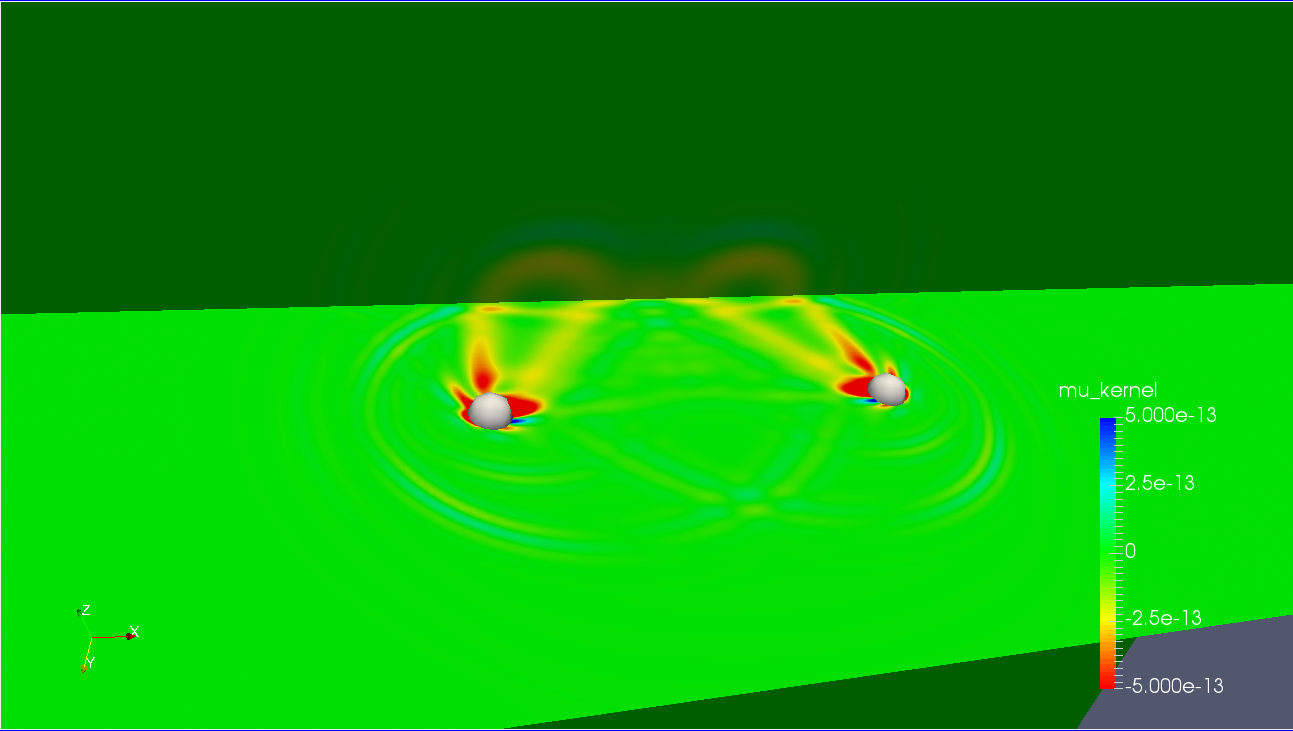

In [27]:
Image("PSSP_mu_kernel_3D.png")

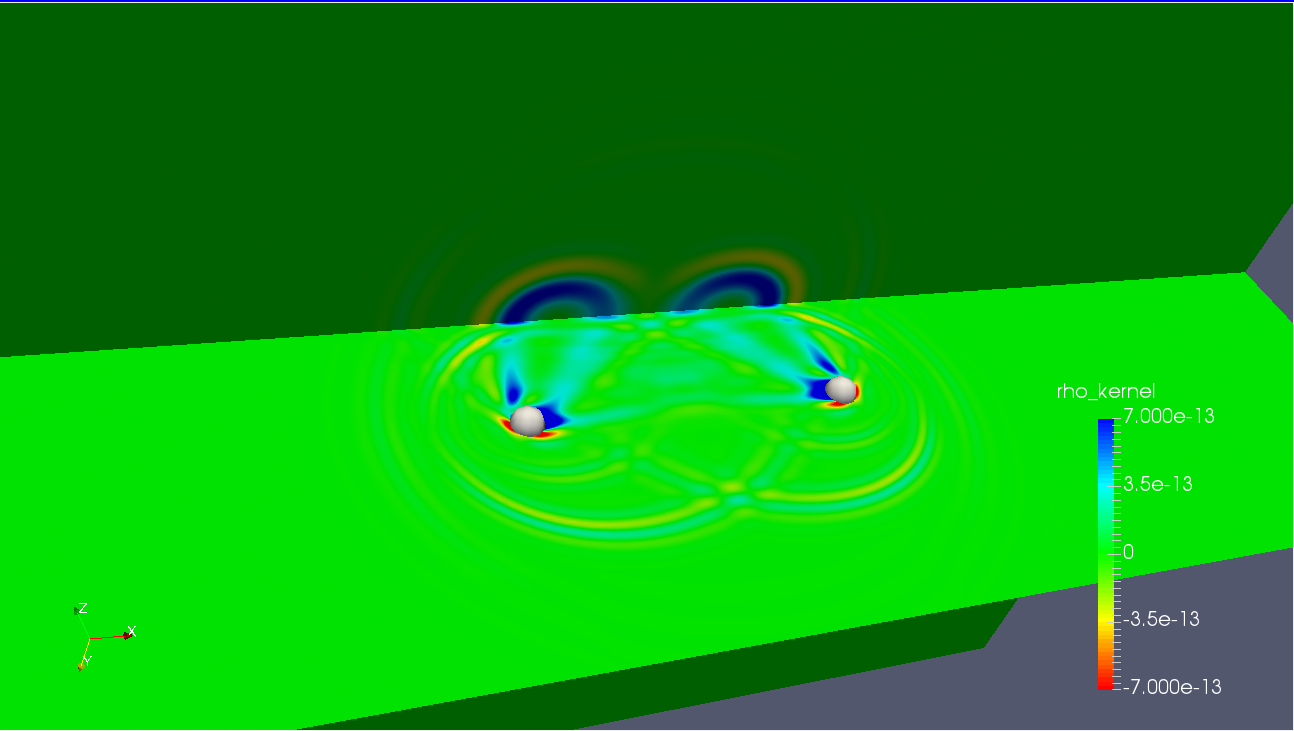

In [28]:
Image("PSSP_rho_kernel_3D.png")

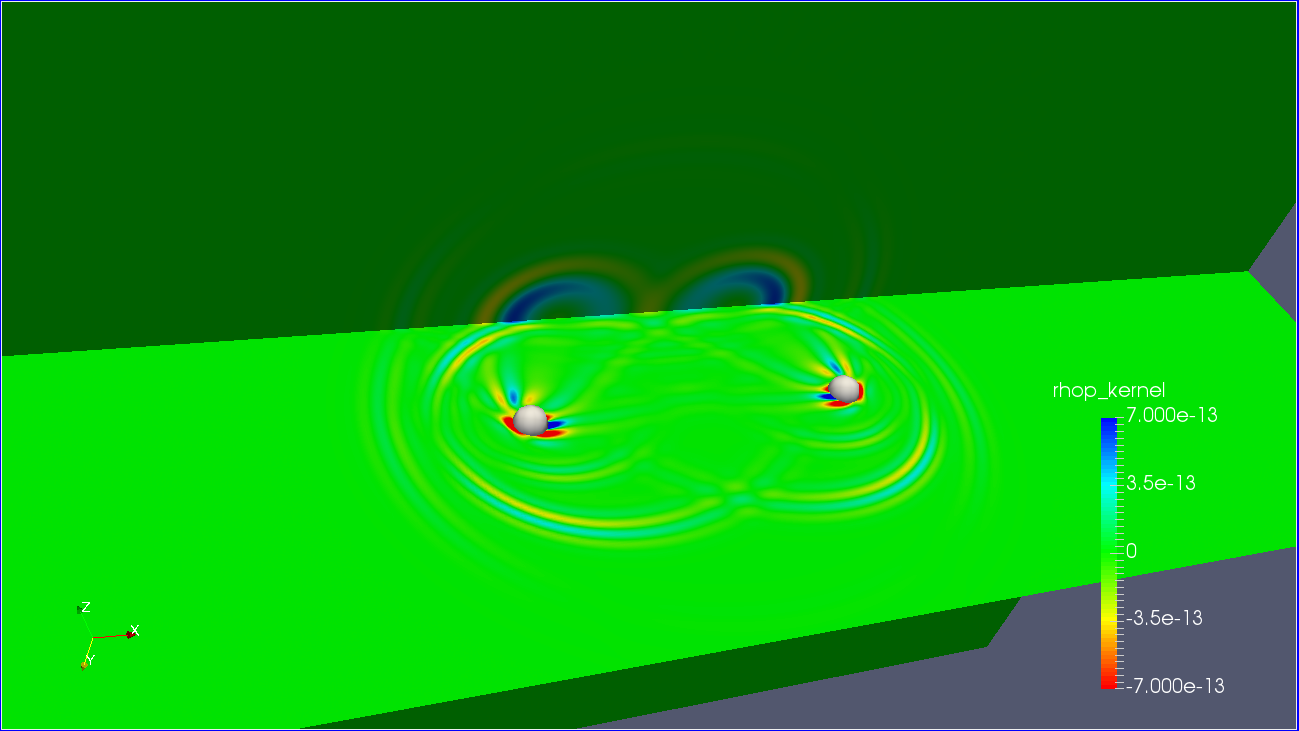

In [29]:
Image("PSSP_rhop_kernel_3D.png")

-----------

**Congratulations! You have reached your destination.**